# Introduction

In this machine learning project, we'll be applying the k-nearest neighbors (KNN) algorithm to predict a car's market price. The dataset we will be working is from the [UCI Machine Learning Repository ](https://archive.ics.uci.edu/dataset/10/automobile) and contains information on various cars. 

For each car, we have information about the technical aspects of the vehicle such as the motor's displacement, the weight of the car, the miles per gallon, how fast the car accelerates, and more. 

At the end of the project, we'll present our findings and show which features are most able to predict a car's price.

## Initial Inspection

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import operator
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 99

In [2]:
# Column names taken from the site hosting the dataset
cols = ['symboling', 'normalized-losses', 'make', 'fuel-type',
        'aspiration', 'num-of-doors', 'body-style', 'drive-wheels', 
        'engine-location', 'wheel-base', 'length', 'width', 'height',
        'curb-weight', 'engine-type', 'num-of-cylinders', 'engine-size',
        'fuel-system', 'bore', 'stroke', 'compression-rate', 'horsepower',
        'peak-rpm', 'city-mpg', 'highway-mpg', 'price']

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data"
cars = pd.read_csv(url, names=cols)

cars.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


In [3]:
print(f'\033[1mNumber of rows:\033[0m\t\t  {cars.shape[0]:,}'
      f'\033[1m\nNumber of columns:\033[0m \t  {cars.shape[1]:,}'
      f'\n\033[1mNumber of missing values:\033[0m {cars.isnull().sum().sum()}')

Number of rows:		  205
Number of columns: 	  26
Number of missing values: 0


In [4]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized-losses  205 non-null    object 
 2   make               205 non-null    object 
 3   fuel-type          205 non-null    object 
 4   aspiration         205 non-null    object 
 5   num-of-doors       205 non-null    object 
 6   body-style         205 non-null    object 
 7   drive-wheels       205 non-null    object 
 8   engine-location    205 non-null    object 
 9   wheel-base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb-weight        205 non-null    int64  
 14  engine-type        205 non-null    object 
 15  num-of-cylinders   205 non-null    object 
 16  engine-size        205 non

There are 26 columns in the dataset. 

However, we will only be working with those containing [continuous numerical values](https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.names).

We'll create a new dataframe comprising these columns. Furthermore, we'll also include `num-of-cylinders`, though non-continuous, but could prove useful in our price prediction.

In [5]:
# Select only the columns with continuous values from - https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.names
continuous_values_cols = ['normalized-losses', 'wheel-base', 'length',
                          'width', 'height', 'curb-weight', 'num-of-cylinders',
                          'engine-size', 'bore', 'stroke', 'compression-rate',
                          'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
numeric_cars = cars[continuous_values_cols]

In [6]:
numeric_cars.head()

,normalized-losses,wheel-base,length,width,height,curb-weight,num-of-cylinders,engine-size,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,?,88.6,168.8,64.1,48.8,2548,four,130,3.47,2.68,9.0,111,5000,21,27,13495
1,?,88.6,168.8,64.1,48.8,2548,four,130,3.47,2.68,9.0,111,5000,21,27,16500
2,?,94.5,171.2,65.5,52.4,2823,six,152,2.68,3.47,9.0,154,5000,19,26,16500
3,164,99.8,176.6,66.2,54.3,2337,four,109,3.19,3.40,10.0,102,5500,24,30,13950
4,164,99.4,176.6,66.4,54.3,2824,five,136,3.19,3.40,8.0,115,5500,18,22,17450


## Data Cleaning

Based on the data set preview above, we noticed that the `normalized-losses` column contains missing values represented by `"?"`. 

Since missing values aren't valuable inputs for predictive modeling, we'll need to replace or remove them. To ensure that the data is usable, we'll be scanning for missing values in other columns. 

Additionally, we'll convert those numbers expressed as strings into numeric values.

In [7]:
convert_num = {'two':2, 'three':3, 'four':4, 'five':5,
              'six':6, 'eight':8, 'twelve':12}

# Replace string values with numeric values in 'num-of-cylinders' column
numeric_cars['num-of-cylinders'] = numeric_cars['num-of-cylinders'].replace(convert_num)

# Verify that the changes have been made
print(numeric_cars['num-of-cylinders'].value_counts())

4     159
6      24
5      11
8       5
2       4
3       1
12      1
Name: num-of-cylinders, dtype: int64


/var/folders/gm/df7gtrln0ml0b31n9l6t167w0000gn/T/ipykernel_11333/1600432944.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cars['num-of-cylinders'] = numeric_cars['num-of-cylinders'].replace(convert_num)


Besides `normalized-losses`, we see that columns `bore`, `stroke`, `horsepower`, `peak-rpm` having `obj` dtypes too. We'll search for and replace the missing values with `NaN`.

In [8]:
col = ['normalized-losses', 'bore', 'stroke', 'horsepower',
       'peak-rpm', 'num-of-cylinders']

for i in col:
    print(numeric_cars[i].loc[numeric_cars[i] == '?'].count())

41
4
4
2
2
0


In [9]:
# Apply pd.to_numeric to the dataframe
numeric_cars = numeric_cars.apply(pd.to_numeric, errors='coerce')

# Verify there are no more obj dtypes in dataframe
numeric_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   normalized-losses  164 non-null    float64
 1   wheel-base         205 non-null    float64
 2   length             205 non-null    float64
 3   width              205 non-null    float64
 4   height             205 non-null    float64
 5   curb-weight        205 non-null    int64  
 6   num-of-cylinders   205 non-null    int64  
 7   engine-size        205 non-null    int64  
 8   bore               201 non-null    float64
 9   stroke             201 non-null    float64
 10  compression-rate   205 non-null    float64
 11  horsepower         203 non-null    float64
 12  peak-rpm           203 non-null    float64
 13  city-mpg           205 non-null    int64  
 14  highway-mpg        205 non-null    int64  
 15  price              201 non-null    float64
dtypes: float64(11), int64(5)
m

In [10]:
# Change dataframe to floating dtype
numeric_cars.astype('float')

# Check for missing values
numeric_cars.isnull().sum()

normalized-losses    41
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
num-of-cylinders      0
engine-size           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

Because `price` is the column we want to predict, we'll remove rows with missing `price` values.

For the other columns, we will replace the missing values using their respective columns' average values.

In [11]:
# Remove rows with missing values in price column
numeric_cars = numeric_cars.dropna(subset=['price'])

# Replace null values with column average
numeric_cars = numeric_cars.fillna(numeric_cars.mean())

# Verify there are no more null values
print(f'\n\033[1mNumber of missing values:\033[0m {numeric_cars.isnull().sum().sum()}')


Number of missing values: 0


We now have no missing values in our dataset.

Next, to prevent any single column from having too much of an impact on the distance, we will normalize all of the columns, other than `price` to have a mean of 0 and a standard deviation of 1.

Normalizing the values preserves the distribution of the values in each column while aligning the scales.

In [12]:
# Use Min-max normalization to perform a linear transformation 
# on all columns other than the price column
price_col = numeric_cars['price']
numeric_cars = (numeric_cars - numeric_cars.mean())/ numeric_cars.std()

numeric_cars['price'] = price_col

In [13]:
numeric_cars.head()

,normalized-losses,wheel-base,length,width,height,curb-weight,num-of-cylinders,engine-size,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,0.000000,-1.680910,-0.438315,-0.851335,-2.029015,-0.014821,-0.342804,0.075201,0.519597,-1.825369,-0.290709,0.203476,-0.245942,-0.650624,-0.540937,13495.0
1,0.000000,-1.680910,-0.438315,-0.851335,-2.029015,-0.014821,-0.342804,0.075201,0.519597,-1.825369,-0.290709,0.203476,-0.245942,-0.650624,-0.540937,16500.0
2,0.000000,-0.708334,-0.243544,-0.185134,-0.558319,0.516789,1.544965,0.604724,-2.427374,0.674254,-0.290709,1.354267,-0.245942,-0.961995,-0.687669,16500.0
3,1.312654,0.165335,0.194690,0.147966,0.217881,-0.422710,-0.342804,-0.430252,-0.524899,0.452769,-0.041019,-0.037387,0.799836,-0.183569,-0.100741,13950.0
4,1.312654,0.099398,0.194690,0.243137,0.217881,0.518722,0.601081,0.219617,-0.524899,0.452769,-0.540399,0.310527,0.799836,-1.117680,-1.274597,17450.0


/Users/eugene/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


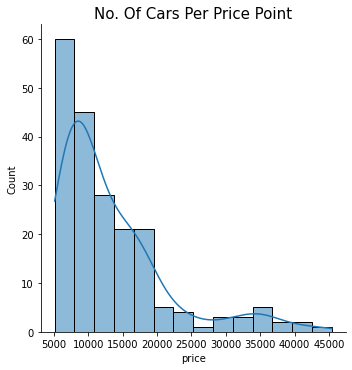

In [14]:
sns.displot(numeric_cars['price'], kde=True)
plt.title('No. Of Cars Per Price Point', fontsize=15)
plt.show()

## Univariate Model

Now that the data is clean and ready for further modeling, we're going to apply the test/train validation approach.

We'll create univariate and multivariate KNN models, estimate the error for each case, and select the model with the lowest errors.

In [15]:
def knn_train_test(train_cols, target_col, df, k=5):
    
    # Test if train column is a single (string) or multi (list) column 
    x = df[train_cols] if isinstance(train_cols, list) else df[[train_cols]]
    y = df[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(
        x, y, test_size=0.5, random_state=1)
        
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    predictions = knn.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    return mse**(0.5)

In [16]:
rmse_default = {}

# Isolating all the numeric columns except for `price` as train columns
train_cols = numeric_cars.columns.drop('price')

# Creating a univariate model for each column using the default value of k and adding each RMSE
# to the dictionary
for col in train_cols:
    rmse = knn_train_test(col, 'price', numeric_cars)
    rmse_default[col] = round(rmse)

# Sorting the dictionary by RMSE in ascending order
sorted_rmse_default = dict(sorted(rmse_default.items(), key=operator.itemgetter(1)))
sorted_rmse_default

{'engine-size': 3542,
 'curb-weight': 3824,
 'horsepower': 3919,
 'width': 4375,
 'highway-mpg': 4382,
 'city-mpg': 4608,
 'num-of-cylinders': 5675,
 'length': 5799,
 'wheel-base': 5820,
 'compression-rate': 6258,
 'bore': 6646,
 'stroke': 7607,
 'height': 7932,
 'peak-rpm': 8121,
 'normalized-losses': 9107}

With the `k` value set at 5, we observe that among a car's attributes, the model using `engine-size` had the highest predictive ability, with an RMSE of \$3,542 while it's `normalized-losses` was the weakest predictor, with an RMSE of $9,107.

Now, one of the ways to improve the model is by tweaking the `k` values. Below, we'll vary `k`, using odd numbers from 1 to 9, to model price predictions for each attribute.

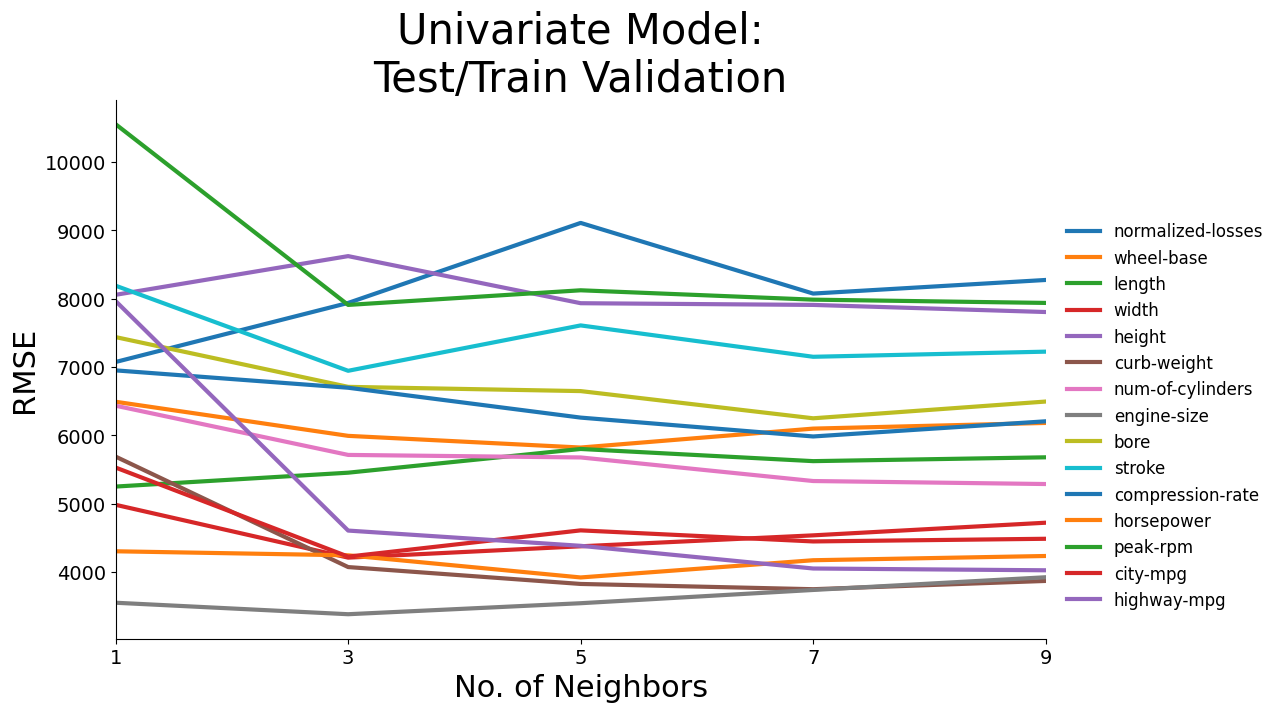

In [17]:
k_rmse_results = {}

plt.figure(figsize=(12,7))

# Creating univariate models for each column with various values of k, adding each RMSE 
# to the dictionary, and plotting the results for all variables
for col in train_cols:
    k_rmse_results[col] = []
    for k in [1,3,5,7,9]:
        rmse = knn_train_test(col, 'price', numeric_cars, k)
        k_rmse_results[col].append(round(rmse))
    plt.plot(list(range(1,10,2)), k_rmse_results[col], linewidth=3) 
    
plt.title('Univariate Model:\nTest/Train Validation', fontsize=30)
plt.xlabel('No. of Neighbors', fontsize=22)
plt.ylabel('RMSE', fontsize=22)
plt.xticks([1,3,5,7,9], fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(1,9)
plt.legend(train_cols, frameon=False, bbox_to_anchor=(1.25, 0.8), fontsize=12)
sns.despine()
plt.show()

The model with the lowset RMSE was the `engine-size` while the `k` value set at 3. With an RMSE of 3,381, the implication is that we should expect for the model to be off by $3,381 on average for the predicted price values.

Given that out of the 201 cars in the dataset, 98 of them were listed below $10,000, we'll need to reduce this error as much as possible to improve the model's usefulness.

## Multivariate Model

We mentioned earlier that one of the ways we could improve a model's accuracy is by increasing the `k` values (number of nearby neighbors) the model uses when computing the prediction. 

Another way would be to increase the number of attributes the model uses to calculate similarity when ranking the closest neighbors. 

To increase the chances of model improvement, we'll only select features with the lowest average RMSE.

In [18]:
feature_avg_rmse = {}
for col in k_rmse_results:
    avg_rmse = np.mean(k_rmse_results[col])
    feature_avg_rmse[col] = avg_rmse
    
series_avg_rmse = pd.Series(feature_avg_rmse).sort_values()
series_avg_rmse

engine-size          3626.0
horsepower           4173.6
curb-weight          4239.4
width                4564.2
city-mpg             4658.0
highway-mpg          5004.8
length               5559.6
num-of-cylinders     5687.0
wheel-base           6115.6
compression-rate     6417.6
bore                 6706.2
stroke               7421.8
height               8063.6
normalized-losses    8092.0
peak-rpm             8499.8
dtype: float64

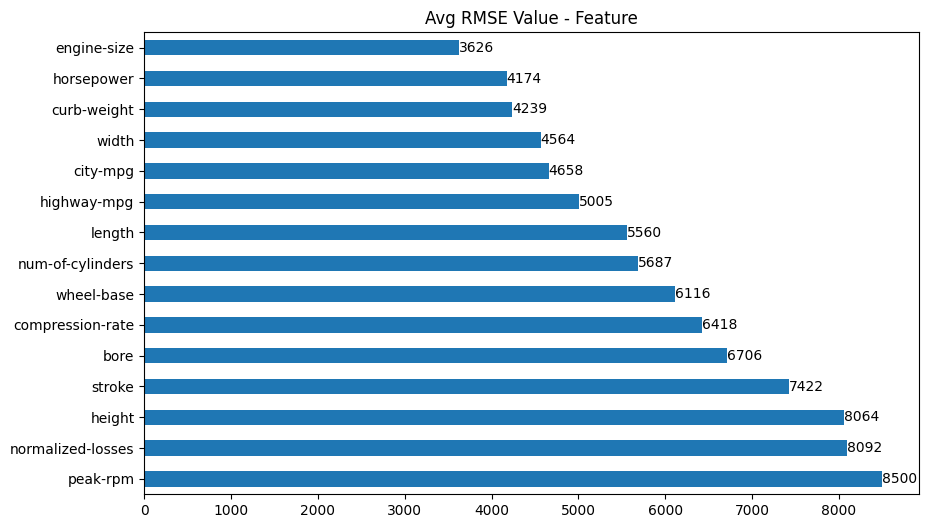

In [19]:
plt.figure(figsize=(10,6))
# horizontal bar plot of uni_rmse Series
ax = series_avg_rmse.sort_values(ascending = False).plot.barh(figsize=(10, 6)) 

# Add value labels to each bar
for index, value in enumerate(series_avg_rmse.sort_values(ascending=False)):
    ax.text(value, index, f'{value:.0f}', ha='left', va='center', color='black')
    
plt.title('Avg RMSE Value - Feature')
plt.show()

The 6 features with the lowest RMSE: `engine-size`, `horsepower`, `curb-weight`, `width`, `city-mpg`, and `highway-mpg`.

Given the outperformance of `engine-size`, it comes as no surprise that it is included in the different combinations we'll be testing for our multivariate model:
- `engine-size`, `horsepower`
- `engine-size`, `horsepower`, `curb-weight`
- `engine-size`, `horsepower`, `curb-weight`, `width`
- `engine-size`, `horsepower`, `curb-weight`, `width`, `city-mpg`
- `engine-size`, `horsepower`, `curb-weight`, `width`, `city-mpg`, `highway-mpg`

In [20]:
k_rmse_multivariate = []

for num_feats in range(2,7):
    # Selecting from 2 to 6 best features
    train_cols_list = list(series_avg_rmse.keys())[:num_feats]
    # Creating a multivariate model for each combination of features using the default k=5 
    # and rounding the resulting RMSE
    rmse = round(knn_train_test(train_cols_list, 'price', numeric_cars))
    # Creating a string representation of selected features
    feature_str = ', '.join(train_cols_list)
    # Appending the RMSE value of each multivariate model to the list
    k_rmse_multivariate.append(f"{feature_str}: {rmse}")
        
k_rmse_multivariate

['engine-size, horsepower: 3554',
 'engine-size, horsepower, curb-weight: 3481',
 'engine-size, horsepower, curb-weight, width: 3412',
 'engine-size, horsepower, curb-weight, width, city-mpg: 3439',
 'engine-size, horsepower, curb-weight, width, city-mpg, highway-mpg: 3408']

All the models had lower error terms, and thus better predictive ability compared to `engine-size` by itself, going to show that the right combination of features, can outdo well-performing standalone features.

The top 3 models were:
1. Six-Feature Model: `engine-size`, `horsepower`, `curb-weight`, `width`, `city-mpg`, `highway-mpg`: \$3,408
2. Four-Feature Model: `engine-size`, `horsepower`, `curb-weight`, `width`: $3,412
3. Five-Feature Model: `engine-size`, `horsepower`, `curb-weight`, `width`, `city-mpg`: \$3,439

Below, we'll expand grid search all the way to a `k` value of 25. While 25 may seem like an arbitrary ending point for our grid search, we can always expand the values we try if we're unconvinced that the lowest MSE value is associated with one of the hyperparameter values we tried so far.

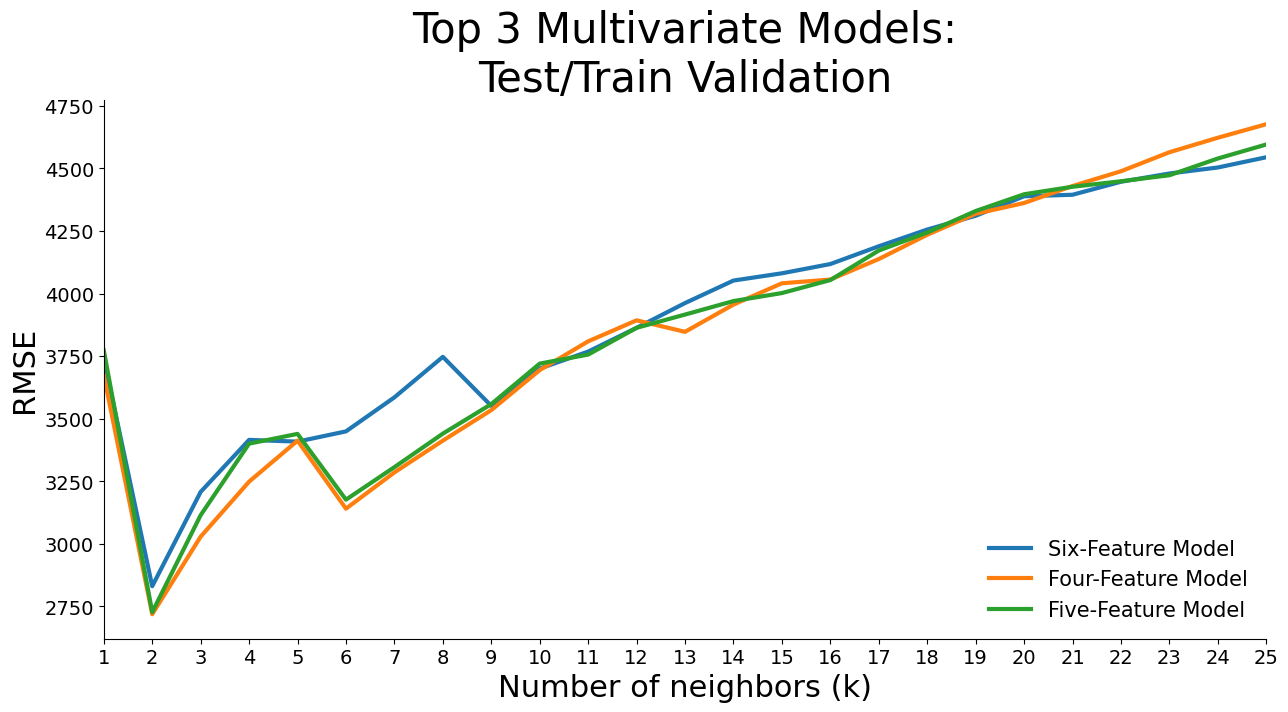

In [21]:
six_feature_model = ['engine-size', 'horsepower', 'curb-weight', 'width', 'city-mpg', 'highway-mpg']
four_feature_model = ['engine-size', 'horsepower', 'curb-weight', 'width']
five_feature_model = ['engine-size', 'horsepower', 'curb-weight', 'width', 'city-mpg']

train_cols_list = [six_feature_model, four_feature_model, five_feature_model]
    
rmse_multivar_various_k = {}

plt.figure(figsize=(15, 7))

# Create multivariate models for each feature combination with k ranging from 1 to 25
for idx, lst in enumerate(train_cols_list):
    combination_num = idx + 1
    rmse_multivar_various_k[combination_num] = {}
    for k in range(1, 26):
        rmse = knn_train_test(lst, 'price', numeric_cars, k)
        rmse_multivar_various_k[combination_num][k] = round(rmse)
    
    plt.plot(list(range(1, 26)),
             list(rmse_multivar_various_k[combination_num].values()), 
             label=f'Combination {combination_num}',
             linewidth=3)
    
plt.title('Top 3 Multivariate Models:\nTest/Train Validation', fontsize=30)
plt.xlabel('Number of neighbors (k)', fontsize=22)
plt.ylabel('RMSE', fontsize=22)
plt.xlim(1,25)
plt.xticks(list(range(1,26)), fontsize=14)
plt.yticks(fontsize=14)

# Use model names as labels in the legend
legend_labels = ['Six-Feature Model', 'Four-Feature Model', 'Five-Feature Model']
plt.legend(legend_labels, frameon=False, loc=4, bbox_to_anchor=None, fontsize=15)

sns.despine()
plt.show()

In [22]:
min_rmse_per_model = {}

for model, rmse in rmse_multivar_various_k.items():
    min_rmse = min(rmse.values())  # Find the minimum value within the sub-dictionary
    min_rmse_per_model[model] = min_rmse

print(min_rmse_per_model)

{1: 2830, 2: 2718, 3: 2726}


All 3 models performed the best when `k` number of neighbours was set at 2. From then on, we see the RMSE increasing steadily as the number of neighbors increased.

The Four-Feature model had the lowest RMSE at 2718, with the Five-Feature model not too far behind at 2726.

Since our goal from the start was to identify the model with the smallest error in car price prediction, we'll review our top results for both the univariate and multivariate models:

**Univariate Models**
- Default `k`=5: `engine-size` (RMSE = 3542)
- Optimal `k`=3: `engine-size` (RMSE = 3381)

**Multivariate Models**
- Default `k`=5: Six-Feature model of `engine-size`, `horsepower`, `curb-weight`, `width`, `city-mpg`, `highway-mpg` (RMSE = 3408)
- Optimal `k`=2: Four-Feature model of `engine-size`, `horsepower`, `curb-weight`, `width` (RMSE = 2718)
- Notable mention `k`=3: Four-Feature model of `engine-size`, `horsepower`, `curb-weight`, `width` (RMSE = 3028)

**In conclusion:**

After evaluating different KNN models with varying numbers of neighbors, it is evident that the Four-Feature model with `k`=2 has the highest predictive ability compared to other models. However, considering the low `k` value of 2, this model might be sensitive to noise. A more balanced option could be the Four-Feature model with k=3, which still maintains a notably lower RMSE while addressing noise influence.

This project provided insights into the K-Nearest Neighbors machine learning algorithm and its application in predicting car prices.